In [13]:
import pandas as pd

# File paths
human_eval_path = "cold_case_analyzer/data/gpt_evaluation_ranking_human.csv"
geval_eval_path = "cold_case_analyzer/data/evaluations/geval_evaluation_detailed_20250213_092412.csv"
bertopic_eval_path = "cold_case_analyzer/data/evaluations/bertopic_evaluation_detailed_20250213_092231.csv"

# Load the data
dataframes = {
    "human_eval": pd.read_csv(human_eval_path),
    "geval_eval": pd.read_csv(geval_eval_path),
    "bertopic_eval": pd.read_csv(bertopic_eval_path),
}

# Rename 'Column metric' in human_eval to match others
dataframes["human_eval"].rename(columns={"Column metric": "Column"}, inplace=True)

# Define a mapping to standardize column names in human_eval
column_mapping = {
    "Abstract Accuracy": "Abstract",
    "Abstract Conciseness": "Abstract",
    "Relevant Facts Accuracy": "Relevant facts / Summary of the case",
    "Relevant Facts Focus on PIL": "Relevant facts / Summary of the case",
    "Relevant Facts Conciseness": "Relevant facts / Summary of the case",
    "PIL Provisions Adherence to Format": "PIL provisions",
    "PIL Provisions Accuracy": "PIL provisions",
    "Choice of Law Issue Classification Accuracy": "Choice of law issue",
    "Choice of Law Issue Correct Identification of CoLI": "Choice of law issue",
    "Choice of Law Issue Precision of Phrasing": "Choice of law issue",
    "Court's Position Does it Answer the CoLI": "Court's position",
    "Court's Position Conciseness": "Court's position",
}

dataframes["human_eval"]["Column"] = dataframes["human_eval"]["Column"].replace(column_mapping)

# Filter only common IDs
common_ids = set(dataframes["geval_eval"]["ID"]) & set(dataframes["bertopic_eval"]["ID"])
human_filtered = dataframes["human_eval"][dataframes["human_eval"]["ID"].isin(common_ids)]

# Merge datasets
merged_df = human_filtered.merge(dataframes["geval_eval"], on=["ID", "Column"], suffixes=('_human', '_geval'))
merged_df = merged_df.merge(dataframes["bertopic_eval"], on=["ID", "Column"])

# Compute BERTScore average
#merged_df["BERT_Avg"] = merged_df[["BERT_Precision", "BERT_Recall", "BERT_F1"]].mean(axis=1)
merged_df["BERT_Avg"] = merged_df["BERT_F1"]

# Compute correlation overall
correlation_matrix = merged_df[["Human_score", "G_Eval_Score", "BERT_F1"]].corr()
correlation_matrix.to_csv("cold_case_analyzer/data/evaluations/evaluation_correlation_matrix.csv")

# Compute correlation per category
category_correlation = merged_df.groupby("Column")[["Human_score", "G_Eval_Score", "BERT_F1"]].corr()
category_correlation.to_csv("cold_case_analyzer/data/evaluations/evaluation_correlation_per_category.csv")

# Save outputs
merged_df.to_csv("cold_case_analyzer/data/evaluations/merged_evaluation_data.csv", index=False)

# Print results
print("Merged dataset saved as merged_evaluation_data.csv")
print("Overall correlation matrix saved as evaluation_correlation_matrix.csv")
print(correlation_matrix)
print("Category-wise correlation matrix saved as evaluation_correlation_per_category.csv")
print(category_correlation)


Merged dataset saved as merged_evaluation_data.csv
Overall correlation matrix saved as evaluation_correlation_matrix.csv
              Human_score  G_Eval_Score   BERT_F1
Human_score      1.000000     -0.018741  0.201847
G_Eval_Score    -0.018741      1.000000  0.316416
BERT_F1          0.201847      0.316416  1.000000
Category-wise correlation matrix saved as evaluation_correlation_per_category.csv
                                                   Human_score  G_Eval_Score  \
Column                                                                         
Abstract                             Human_score      1.000000     -0.456690   
                                     G_Eval_Score    -0.456690      1.000000   
                                     BERT_F1          0.105640      0.415417   
Choice of law issue                  Human_score      1.000000      0.434890   
                                     G_Eval_Score     0.434890      1.000000   
                                     

/tmp/ipykernel_22612/1276475094.py:10: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  "human_eval": pd.read_csv(human_eval_path),


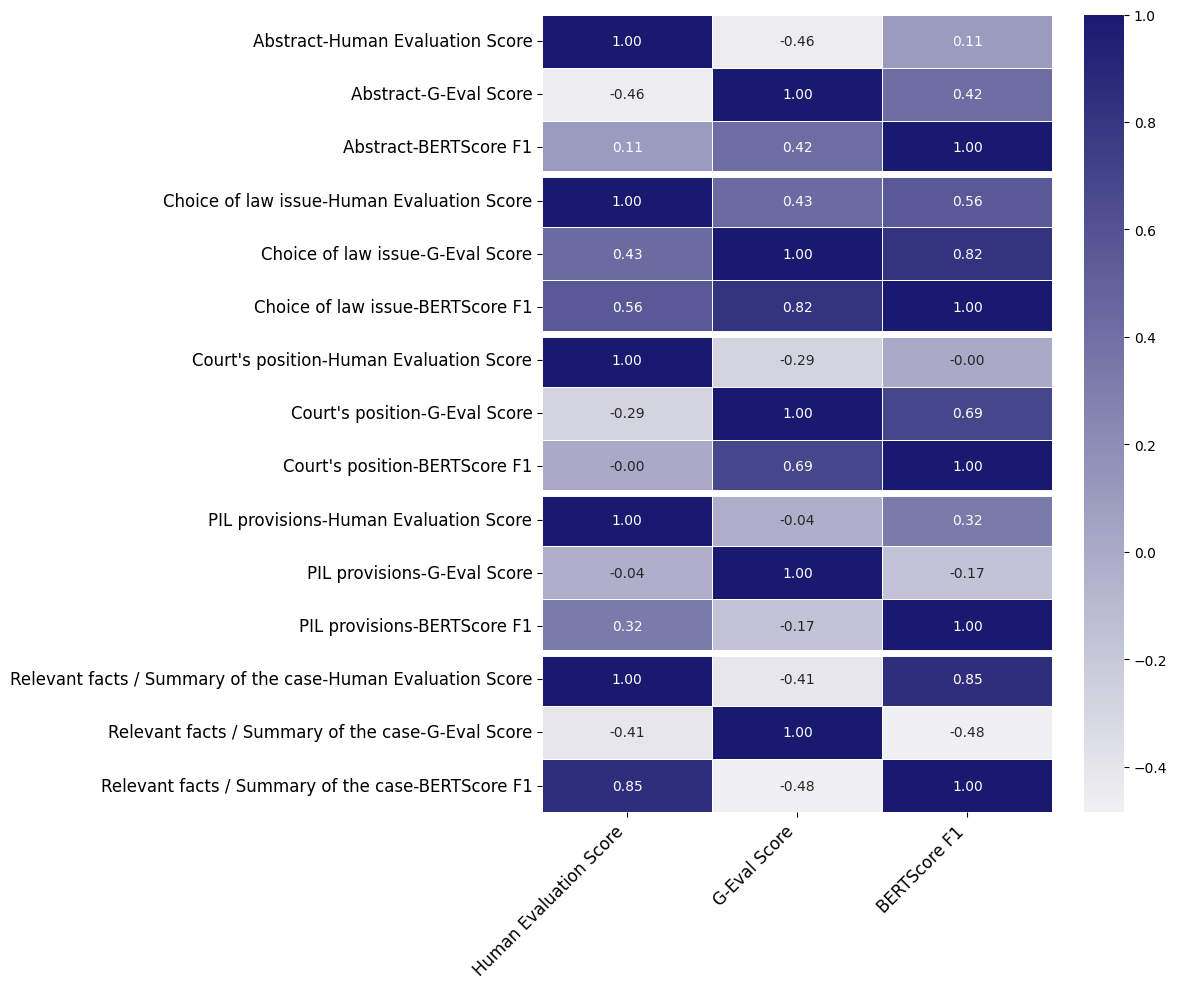

'category_correlation_heatmap_with_separators.png'

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Update the labels for better expressiveness
renamed_columns = {
    "Human_score": "Human Evaluation Score",
    "G_Eval_Score": "G-Eval Score",
    "BERT_F1": "BERTScore F1",
}

category_correlation_renamed = category_correlation.rename(columns=renamed_columns, index=renamed_columns)

# Extract row indices where a new category begins
category_labels = [index[0] for index in category_correlation_renamed.index]
unique_categories = list(dict.fromkeys(category_labels))  # Preserve order
category_boundaries = [category_labels.index(cat) for cat in unique_categories][1:]  # Skip first category

# Create a masked version of the correlation data
masked_data = category_correlation_renamed.copy()

# Define a mask where all values <= 0 should be white
mask = masked_data <= 0

# Create the figure and heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(category_correlation_renamed, annot=True, fmt=".2f", cmap=sns.light_palette("midnightblue", as_cmap=True), linewidths=0.5, cbar=True) #mako_r, crest, rocket_r, flare

# Add horizontal lines to separate categories
for boundary in category_boundaries:
    ax.hlines(y=boundary, xmin=0, xmax=len(category_correlation_renamed.columns), color="white", linewidth=5)

# Update title and axis labels
#plt.title("Category-wise Correlation of Evaluation Metrics", fontsize=14)
plt.ylabel("")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the updated figure
updated_plot_path = "category_correlation_heatmap_with_separators.png"
plt.savefig(updated_plot_path, dpi=300)

# Display the updated figure
plt.show()

# Provide the file path for download
updated_plot_path


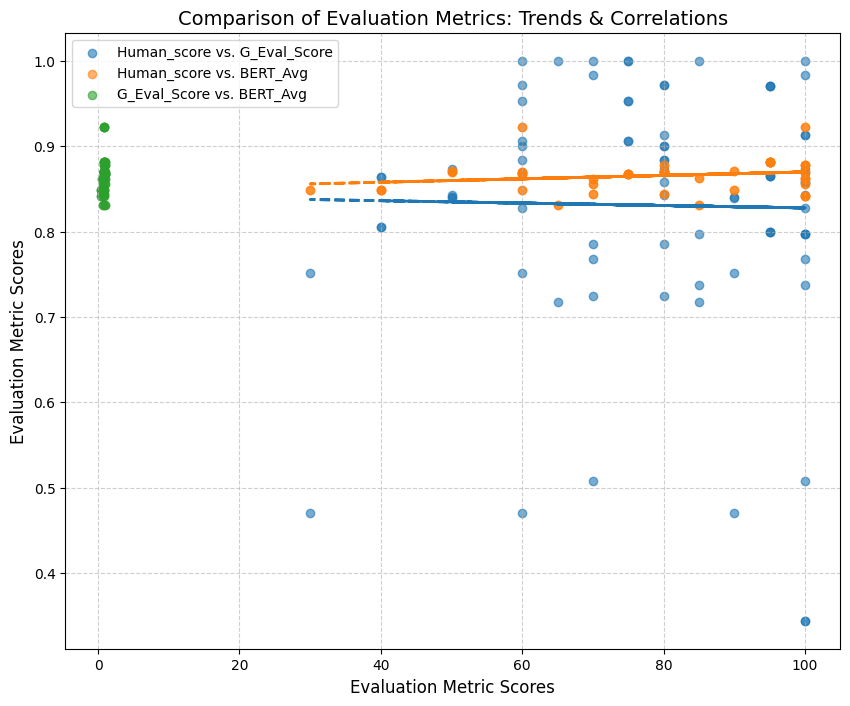

'evaluation_scatter_plot.png'

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Update the labels for better expressiveness
renamed_columns = {
    "Human_score": "Human Evaluation Score",
    "G_Eval_Score": "G-Eval Score",
    "BERT_F1": "BERTScore F1",
}

category_correlation_renamed = category_correlation.rename(columns=renamed_columns, index=renamed_columns)

# Extract row indices where a new category begins
category_labels = [index[0] for index in category_correlation_renamed.index]
unique_categories = list(dict.fromkeys(category_labels))  # Preserve order
category_boundaries = [category_labels.index(cat) for cat in unique_categories][1:]  # Skip first category

# Create a masked version of the correlation data
masked_data = category_correlation_renamed.copy()

# Define a mask where all values <= 0 should be white
mask = masked_data <= 0

# Create the figure and heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    masked_data, 
    annot=True, 
    fmt=".2f", 
    cmap=sns.light_palette("midnightblue", as_cmap=True), 
    linewidths=0.5, 
    cbar=True, 
    mask=mask,  # Apply the mask
    center=0.5  # Adjust the color scale center
)

# Apply white color to the masked areas manually
#ax.set_facecolor("white")

# Add horizontal lines to separate categories
for boundary in category_boundaries:
    ax.hlines(y=boundary, xmin=0, xmax=len(category_correlation_renamed.columns), color="white", linewidth=5)

# Update title and axis labels
#plt.title("Category-wise Correlation of Evaluation Metrics", fontsize=14)
plt.ylabel("")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the updated figure
updated_plot_path = "category_correlation_heatmap_with_separators.png"
plt.savefig(updated_plot_path, dpi=300)

# Display the updated figure
plt.show()

# Provide the file path for download
updated_plot_path


In [22]:
print(results_df)

                                              Metric  Human_count  Human_mean  \
0                  Court's Position - Answering CoLI           33    0.875758   
1                 Rules of Law - Adherence to Format           33    0.845455   
2                     Court's Position - Conciseness           33    0.839394   
3  Choice of Law Issue - Correct Identification o...           33    0.745455   
4                            Rules of Law - Accuracy           33    0.846970   
5                                Abstract - Accuracy           33    0.774242   
6      Choice of Law Issue Classification - Accuracy           33    0.718182   
7        Choice of Law Issue - Precision of Phrasing           33    0.784848   
8                             Abstract - Conciseness           33    0.850000   

   G_Eval_count  G_Eval_mean  F_statistic   p_value  
0            33     0.829998     2.108945  0.151325  
1            33     0.636016     6.410682  0.013809  
2            33     0.81431

/tmp/ipykernel_12667/44173409.py:9: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_human = pd.read_csv("cold_case_analyzer/data/gpt_evaluation_ranking_human.csv")


                                               Metric  Human_count  \
0   Choice of Law Issue - Correct Identification o...           33   
1         Choice of Law Issue - Precision of Phrasing           33   
2                   Court's Position - Answering CoLI           33   
3                              Abstract - Conciseness           33   
4                           Relevant Facts - Accuracy           33   
5                             Rules of Law - Accuracy           33   
6                      Court's Position - Conciseness           33   
7                                 Abstract - Accuracy           33   
8                        Relevant Facts - Conciseness           33   
9                       Relevant Facts - Focus on PIL           33   
10      Choice of Law Issue Classification - Accuracy           33   
11                 Rules of Law - Adherence to Format           33   

    Human_mean  G_Eval_count  G_Eval_mean  F_statistic       p_value  
0     0.745455    

/tmp/ipykernel_12667/44173409.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Metric"] = df_filtered["Metric"].replace(rename_dict)


ANOVA comparison plot saved to: cold_case_analyzer/data/metric_anova_comparison.png


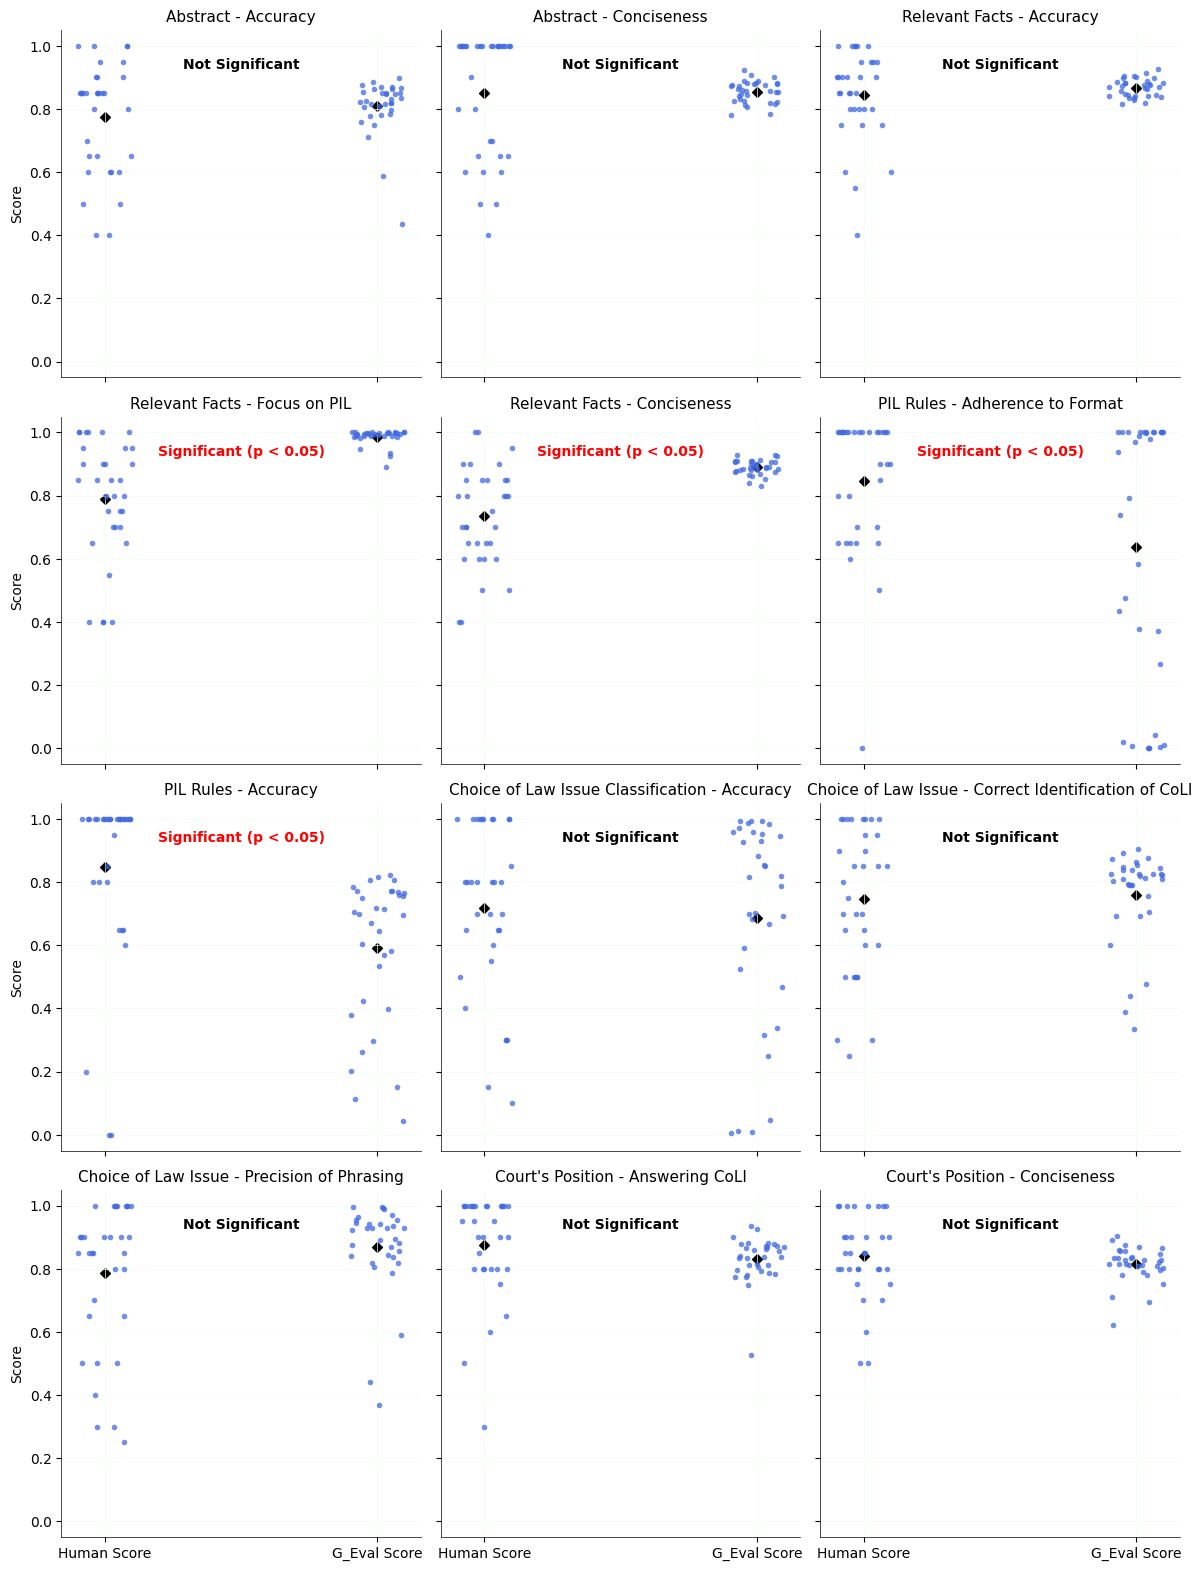

In [17]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load the two files (adjust the file paths if needed)
df_geval = pd.read_csv("cold_case_analyzer/data/evaluations/geval_evaluation_detailed_20250213_194337.csv")
df_human = pd.read_csv("cold_case_analyzer/data/gpt_evaluation_ranking_human.csv")

# **Data Cleaning Step for 'Metric' in df_human**
# Remove everything before and including the first comma in the 'Metric' column
df_human["Metric"] = df_human["Metric"].astype(str).str.split(",").str[-1].str.strip()

# Normalize Human_score (convert percentage to proportion)
df_human["Human_score"] = df_human["Human_score"] / 100

# Find common metrics in both datasets
common_metrics = set(df_geval["Metric"].unique()).intersection(set(df_human["Metric"].unique()))

# Store ANOVA results
results = []

for metric in common_metrics:
    # Extract scores for the current metric
    human_values = df_human[df_human["Metric"] == metric]["Human_score"].dropna().values
    geval_values = df_geval[df_geval["Metric"] == metric]["G_Eval_Score"].dropna().values
    
    # Compute mean scores
    human_mean = np.mean(human_values) if len(human_values) > 0 else np.nan
    geval_mean = np.mean(geval_values) if len(geval_values) > 0 else np.nan
    
    # Ensure both groups have values for ANOVA
    if len(human_values) > 0 and len(geval_values) > 0:
        anova = stats.f_oneway(human_values, geval_values)
        results.append({
            "Metric": metric,
            "Human_count": len(human_values),
            "Human_mean": human_mean,
            "G_Eval_count": len(geval_values),
            "G_Eval_mean": geval_mean,
            "F_statistic": anova.statistic,
            "p_value": anova.pvalue
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save the results DataFrame as a CSV file
results_df.to_csv("cold_case_analyzer/data/metric_anova_results.csv", index=False)
print("ANOVA results saved to: cold_case_analyzer/data/metric_anova_results.csv")

# Merge original score data for plotting
df_long = pd.concat([
    df_human[["Metric", "Human_score"]].rename(columns={"Human_score": "Score"}).assign(Evaluation_Type="Human_score"),
    df_geval[["Metric", "G_Eval_Score"]].rename(columns={"G_Eval_Score": "Score"}).assign(Evaluation_Type="G_Eval_Score")
])

# Filter to include only the common metrics
df_filtered = df_long[df_long["Metric"].isin(common_metrics)]
# Rename "Rules of Law" to "PIL Rules"
#df_filtered.loc[df_filtered["Metric"] == "Rules of Law - Adherence to Format", "Metric"] = "PIL Rules - Adherence to Format"
#df_filtered.loc[df_filtered["Metric"] == "Rules of Law - Accuracy", "Metric"] = "PIL Rules - Accuracy"
rename_dict = {
    "Rules of Law - Adherence to Format": "PIL Rules - Adherence to Format",
    "Rules of Law - Accuracy": "PIL Rules - Accuracy"
}
df_filtered["Metric"] = df_filtered["Metric"].replace(rename_dict)
results_df["Metric"] = results_df["Metric"].replace(rename_dict)


# Define the number of columns per row in the facet grid (adjust for readability)
col_wrap = min(3, len(common_metrics))

# Create a FacetGrid for all metrics
g = sns.FacetGrid(df_filtered, col="Metric", col_wrap=col_wrap, sharey=True, height=4, aspect=1)

# Add jittered scatter points (all data points with variance)
g.map_dataframe(sns.stripplot, x="Evaluation_Type", y="Score", jitter=True, alpha=0.75, color="royalblue", size=4)

# Add mean markers (black diamonds) for each evaluation type within each facet
for ax, metric in zip(g.axes.flat, df_filtered["Metric"].unique()):
    human_mean = df_filtered[(df_filtered["Metric"] == metric) & (df_filtered["Evaluation_Type"] == "Human_score")]["Score"].mean()
    geval_mean = df_filtered[(df_filtered["Metric"] == metric) & (df_filtered["Evaluation_Type"] == "G_Eval_Score")]["Score"].mean()
    
    # Get the corresponding p-value from the ANOVA results
    p_value = results_df[results_df["Metric"] == metric]["p_value"].values[0]
    
    # Define the significance label
    significance_label = "Significant (p < 0.05)" if p_value < 0.05 else "Not Significant"
    
    # Add mean markers
    ax.scatter([0, 1], [human_mean, geval_mean], color="black", marker="D", s=25, label="Mean")
    
    # Annotate significance within the plot
    ax.text(0.5, 0.9, significance_label, ha="center", va="center", transform=ax.transAxes,
            fontsize=10, color="red" if p_value < 0.05 else "black", fontweight="bold")

# Style settings (mimicking ggplot2 theme)
g.set_titles(col_template="{col_name}", size=11)
g.set_axis_labels("", "Score")
g.set(xticks=[0, 1], xticklabels=["Human Score", "G_Eval Score"])
for ax in g.axes.flat:
    ax.grid(color="honeydew", linestyle="-", linewidth=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)

# Save the plot as a PNG file
g.fig.savefig("cold_case_analyzer/data/metric_anova_comparison.png", dpi=600)
print("ANOVA comparison plot saved to: cold_case_analyzer/data/metric_anova_comparison.png")

# Display the plot
plt.show()
